In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = Path("/scratch/sshah/2021-05-25/")
assert DATA_DIR.exists()

# def _cook(p: Path) -> pd.DataFrame
dfs = []
for f in DATA_DIR.glob("*test.csv.zip"):
    dfs.append(pd.read_csv(f))

In [3]:
df = pd.concat(dfs, sort=False)

df.loc[(df.initial_batch_size == df.max_batch_size) & (df.damper == "radadamp"), "damper"] = "radadamplr"

df["epochs_binned"] = np.round(df["epochs"])
df["model_updates_binned"] = np.round(df["model_updates"], decimals=-2)

dampers = {
    "geodamplr": "SGD",
    "geodamp": "GeoDamp",
    "radadamp": "RadaDamp",
    "radadamplr": "RadaDamp-LR",
    "adagrad": "Adagrad",
}

HUE_ORDER = ["SGD", "GeoDamp", "RadaDamp", "RadaDamp-LR", "Adagrad"]
ACC_LIM = (0.85, 0.92)

df["Optimizer"] = df["damper"].apply(dampers.get)

In [4]:
df.head()

,epoch_time,initial_batch_size,max_batch_size,batch_growth_rate,dampingfactor,dampingdelay,epochs,verbose,lr,no_cuda,...,step_time,lr_,batch_size_,_initial_factor,opt_param_lr_decay,opt_param_eps,opt_param_initial_accumulator_value,epochs_binned,model_updates_binned,Optimizer
0,1.621967e+09,256,1024,0.01,5.0,5,0.000000,True,0.005,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,RadaDamp
1,1.621968e+09,256,1024,0.01,5.0,5,1.001646,True,0.005,True,...,0.265678,0.005,260.0,2.237724,NaN,NaN,NaN,1.0,200,RadaDamp
2,1.621968e+09,256,1024,0.01,5.0,5,2.001896,True,0.005,True,...,0.321166,0.005,280.0,2.237724,NaN,NaN,NaN,2.0,400,RadaDamp
3,1.621968e+09,256,1024,0.01,5.0,5,3.005708,True,0.005,True,...,0.285979,0.005,304.0,2.237724,NaN,NaN,NaN,3.0,500,RadaDamp
4,1.621968e+09,256,1024,0.01,5.0,5,4.009542,True,0.005,True,...,0.348318,0.005,330.0,2.237724,NaN,NaN,NaN,4.0,700,RadaDamp


In [5]:
def lineplot(
    *, x, y, hue, hue_order, ax, data, aggfunc="mean",
):
    for h in hue_order:
        show = data[data[hue] == h]
        if not len(show):
            continue
        middle = show.pivot_table(index=x, values=y, aggfunc=aggfunc)
        ax.plot(middle.index, middle.to_numpy(), label=h)
    return ax

PERC_FORMAT = plt.FuncFormatter(lambda x, _: f"{int(100 * x)}%")
MU_FORMAT = plt.FuncFormatter(lambda x, _: f"{int(x / 1000)}")


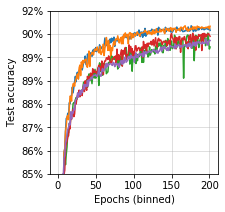

In [6]:
w = 3
fig, ax = plt.subplots(figsize=(w, w))
ax = lineplot(
    x="epochs_binned",
    y="test_accuracy",
    hue="Optimizer",
    hue_order=HUE_ORDER,
    ax=ax,
    data=df,
)
ax.set_ylim(*ACC_LIM)
ax.grid(alpha=0.5)
ax.yaxis.set_major_formatter(PERC_FORMAT)
ax.set_ylabel("Test accuracy")
ax.set_xlabel("Epochs (binned)")
fig.savefig("epochs-acc.png", dpi=300, bbox_inches="tight")

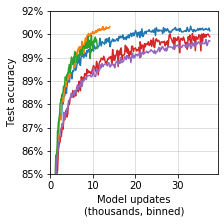

In [14]:
fig, ax = plt.subplots(figsize=(w, w))
ax = lineplot(
    x="model_updates_binned",
    y="test_accuracy",
    hue="Optimizer",
    hue_order=HUE_ORDER,
    ax=ax,
    data=df,
)
# ax.legend(loc="best")
ax.set_ylim(*ACC_LIM)
ax.set_xlim(0, None)
ax.yaxis.set_major_formatter(PERC_FORMAT)
ax.xaxis.set_major_formatter(MU_FORMAT)

ax.grid(alpha=0.5)
ax.set_ylabel("Test accuracy")
ax.set_xlabel("Model updates\n(thousands, binned)")
fig.savefig("acc_mu.png", dpi=300, bbox_inches="tight")

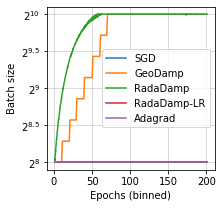

In [13]:
fig, ax = plt.subplots(figsize=(w, w))
ax = lineplot(
    x="epochs",
    y="batch_size_",
    hue="Optimizer",
    hue_order=HUE_ORDER,
    ax=ax,
    data=df,
)
ax.set_yscale("log", basey=2)
ax.grid(alpha=0.6)
ax.set_ylabel("Batch size")
ax.set_xlabel("Epochs (binned)")
ylocs = [2**(i/2) for i in range(8, 30)]
ax.yaxis.set_major_locator(plt.FixedLocator(ylocs))
def _log_fmt(x, _):
    pwr = np.log2(x)
    if abs(pwr % 1.0) < 0.1:
        pwr = int(pwr)
    return "$2^{" + str(pwr) + "}$"
ax.yaxis.set_major_formatter(plt.FuncFormatter(_log_fmt))
fig.savefig("bs.png", dpi=300, bbox_inches="tight")
ax.legend(loc="best")


[16.0, 22.627416997969522, 32.0, 45.254833995939045, 64.0, 90.50966799187809, 128.0, 181.01933598375618, 256.0, 362.03867196751236, 512.0, 724.0773439350247, 1024.0, 1448.1546878700494, 2048.0, 2896.309375740099, 4096.0, 5792.618751480198, 8192.0, 11585.237502960395, 16384.0, 23170.47500592079]


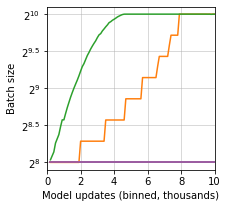

In [10]:
fig, ax = plt.subplots(figsize=(w, w))
ax = lineplot(
    x="model_updates_binned",
    y="batch_size_",
    hue="Optimizer",
    hue_order=HUE_ORDER,
    ax=ax,
    data=df,
)
ax.set_yscale("log", basey=2)
ax.set_xlim(0, 10e3)
ax.grid(alpha=0.6)
ax.xaxis.set_major_formatter(MU_FORMAT)
ax.set_ylabel("Batch size")
ax.set_xlabel("Model updates (binned, thousands)")
ylocs = [2**(i/2) for i in range(8, 30)]
print(ylocs)
# [i/2 for i in range(8, 20)]
ax.yaxis.set_major_locator(plt.FixedLocator(ylocs))
# ax.set_ylim(None, 2**10.1)
def _log_fmt(x, _):
    pwr = np.log2(x)
    if abs(pwr % 1.0) < 0.1:
        pwr = int(pwr)
    return "$2^{" + str(pwr) + "}$"
ax.yaxis.set_major_formatter(plt.FuncFormatter(_log_fmt))


# ax.legend(loc="best")
# ax.set_ylim(0.84, 0.92)
# ax.set_xlim(0, 15e3)
# ax.yaxis.set_major_formatter(PERC_FORMAT)
# ax.grid(alpha=0.5)
# ax.set_ylabel("Test accuracy")
# ax.set_xlabel("Model updates (binned)")
# # ax.set_xscale("log", basex=2)

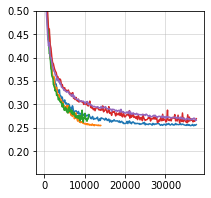

In [11]:
df["model_updates_binned"] = np.round(df["model_updates"], decimals=-2)

fig, ax = plt.subplots(figsize=(w, w))
ax = lineplot(
    x="model_updates_binned",
    y="test_loss",
    hue="Optimizer",
    data=df,
    hue_order=HUE_ORDER,
    ax=ax,
)
# ax.set_ylim(0.84, 0.95)
# ax.yaxis.set_major_formatter(PERC_FORMAT)

ax.set_ylim(None, 0.5)
ax.grid(alpha=0.5)
# ax.set_xscale("log", basex=2)